## Before you run this notebook:
1. Please make sure that you have the "HCV-Egy-Data.csv" file at the same folder of this notebook. If not, please modify the first code cell (right below) accordingly.
2. If you are running on Google's Colab, you may need to mount the Google drive as your storage. Follow the instruction given by Google. 

3. If you are running on a local environment, please comment out the first block inside the very first code cell.

4. If you already have the fabricated data file, please modify the conresponding parameter in the first code cell.

5. The source of the original data is at: [UC Irvine Machine Learining Repository: Hepatitis C Virus (HCV) for Egyptian patients Data Set](https://archive.ics.uci.edu/ml/datasets/Hepatitis+C+Virus+%28HCV%29+for+Egyptian+patients
)

## When you run this code:
1. You may find the number of entries is very limited, so the results of an array of clasiifiers are only marginally better than a random guess. The reason of this ineffectiveness is, according to my guess, due to the limited amount of data and my lack of domain knowledge to implememnt a rule-based classifier or something better. 

2. Despite of the low accuracy, I listed some of the most important features and you could select them for the training. I recommend that you run the whole notebook first so you would get the main logical flow of this document to better assist you modify to your needs. 

3. Since the main purpose of this portion is to help wih the data fabrication. As soon as you have the fabricated data, you could run the classifier on the fabriicated data to check if the accuracy score is close to that on the true dataset. 

4. There is a paper on implementibg a complex classifier for this specific problem. [A novel model based on non invasive methods for prediction of liver fibrosis](https://ieeexplore.ieee.org/document/8289800).  The discretization part of the dataset below is based on the knowledge provided in this paper. However, I was not able to achieve the accuracy from this paper. The knowledge required in duplicating their result is beyond the scope of this course (CMPE 256 in SJSU.)

In [11]:
## ------ Comment this block if run on local machine -----###
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
## ----------------  Block ends  --------------#####


#------ Change below parameters if necessary --------# 
#path = "/content/drive/My Drive/Colab Notebooks/" # change path here 
path = 'C:/Users/swlee/Desktop/syn_models/'
#source_data_file_name = "HCV-Egy-Data.csv"
source_data_file_name = 'hcv.csv'
## ----------------  Block ends  --------------#####

csv_file_path = path + source_data_file_name

In [2]:
#import packages

## Utility tools 
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from time import time
import itertools


## Models 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn import svm
from sklearn.pipeline import Pipeline

## Analysis tools 
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, make_scorer
from sklearn import model_selection
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

## Warning settings 
import warnings
warnings.simplefilter("ignore")


def plot_test_result(clfs, test_score, test_scores):
    names = []
    for i in range(0, len(clfs)): 
        clf = clfs[i]
        clf_name = clf.__class__.__name__
        names.append(clf_name)

    y_pos = np.arange(len(names))

    plt.barh(y_pos, test_scores, align='center')
    plt.yticks(y_pos, names)
    plt.xlim(0.0, 0.99)
    plt.xlabel('Score')
    plt.title('Test Data Accuracy Scores')
    plt.show()


#Splitting the data into Train and Test data sets
def train_models():
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, stratify = labels, random_state=42)
  ## Initializing all models and parameters
  #Initializing classifiers
  RF_clf = RandomForestClassifier(n_estimators = 30, random_state = 1, class_weight = 'balanced')
  AB_clf = AdaBoostClassifier(n_estimators = 30, random_state = 2)
  MLP_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2))
  KNN_clf = KNeighborsClassifier()
  LOG_clf = linear_model.LogisticRegression(multi_class = "ovr", solver = "sag", class_weight = 'balanced')
  GNB_clf = GaussianNB()
  SVM_clf = svm.SVC(gamma='scale', probability=True)
  clfs = [RF_clf, AB_clf, MLP_clf, KNN_clf, LOG_clf, GNB_clf, SVM_clf]

  #Specficying scorer and parameters for grid search
  feature_len = features.shape[1]
  print("Number of selected features:", feature_len)
  scorer = make_scorer(accuracy_score)

  pca_n_components = (list)(range(4, feature_len, 3))
  pca_n_components.append(feature_len)

  parameters_RF = {'clf__max_features': ['auto', 'log2'], 
                  'pca__n_components': pca_n_components}
  parameters_AB = {'clf__learning_rate': np.linspace(0.5, 2, num=10), 
                  'pca__n_components': pca_n_components}
  parameters_MLP = {'pca__n_components': pca_n_components}
  parameters_KNN = {'clf__n_neighbors': [10, 20, 30, 40, 50, 60], 
                    'pca__n_components': pca_n_components}
  parameters_LOG = {'clf__C': np.logspace(1, 1000, 5), 
                    'pca__n_components': pca_n_components}
  parameters_GNB = {'pca__n_components': pca_n_components}
  parameters_SVM = {'pca__n_components': pca_n_components}

  parameters = {clfs[0]: parameters_RF,
                clfs[1]: parameters_AB,
                clfs[2]: parameters_MLP,
                clfs[3]: parameters_KNN,
                clfs[4]: parameters_LOG,
                clfs[5]: parameters_GNB,
                clfs[6]: parameters_SVM}

  #Initializing PCA
  pca = PCA()

  #Creating cross validation data splits
  cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 3, test_size = 0.25, random_state=42)

  #Initialize result storage
  clfs_return = []
  dm_reduce_return = []
  train_scores = []
  test_scores = []

  #Loop through classifiers
  for clf in clfs:

      estimators = [('pca', pca), ('clf', clf)]
      pipeline = Pipeline(estimators)
      
      print("Training a {} with {}...".format(clf.__class__.__name__, pca.__class__.__name__))
      start = time()
      
      #Grid search over pipeline and return best classifier
      grid = model_selection.GridSearchCV(pipeline, param_grid = parameters[clf], scoring = scorer, cv = cv_sets, n_jobs = -1)
      grid.fit(X_train, y_train)
      best_pipe = grid.best_estimator_
      #clf = CalibratedClassifierCV(best_pipe.named_steps['clf'], cv= 'prefit', method='isotonic')
      clf.fit(best_pipe.named_steps['pca'].transform(X_train), y_train)
      dm_reduce = best_pipe.named_steps['pca']
      
      end = time()
      print("Trained {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
      
      #Make predictions of train data
      y_train_pred = clf.predict(best_pipe.named_steps['pca'].transform(X_train))
      train_score = accuracy_score(y_train.values, y_train_pred)
      print("Score of {} for train set: {:.4f}.".format(clf.__class__.__name__, train_score))
      
      #Make predictions of test data
      y_test_pred = clf.predict(best_pipe.named_steps['pca'].transform(X_test))
      test_score = accuracy_score(y_test.values, y_test_pred)
      print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, test_score))
      
      #Append the result to storage            
      clfs_return.append(clf)
      dm_reduce_return.append(dm_reduce)
      train_scores.append(train_score)
      test_scores.append(test_score)

  plot_test_result(clfs, test_score, test_scores)

  #Defining the best classifier
  best_clf = clfs_return[np.argmax(test_scores)]
  best_dm_reduce = dm_reduce_return[np.argmax(test_scores)]
  print("The best classifier is {}".format(best_clf.__class__.__name__))

  return [best_clf,best_dm_reduce]


In [3]:
print('------Read In True Data----------')
headers = ['Age', 'Gender', 'Bmi', 'Fever', 'Nausea/Vomiting', 'Headache',\
           'Diarrhea', 'Fatigue and Bone-ache', 'Jaundice', 'Epigastric pain', 'WBC',\
           'RBC', 'HGB', 'Plat', 'AST 1', 'ALT 1',\
           'ALT 4', 'ALT 12', 'ALT 24', 'ALT 36', 'ALT 48', 'ALT after 24w',\
           'RNA Base', 'RNA 4', 'RNA 12', 'RNA EOT', 'RNA EF',\
           'Baseline histological grading', 'Baseline histological staging']

csv_data = pd.read_csv(csv_file_path, skiprows=1, names=headers)
print(csv_data.head())
print('------OK!----------\n\n\n')

print('------Define features and label(s)----------')
feature_cols = ['Age', 'Gender', 'Bmi', 'Fever', 'Nausea/Vomiting', 'Headache',\
           'Diarrhea', 'Fatigue and Bone-ache', 'Jaundice', 'Epigastric pain', 'WBC',\
           'RBC', 'HGB', 'Plat', 'AST 1', 'ALT 1',\
           'ALT 4', 'ALT 12', 'ALT 24', 'ALT 36', 'ALT 48', 'ALT after 24w',\
           'RNA Base', 'RNA 4', 'RNA 12', 'RNA EOT', 'RNA EF',\
           'Baseline histological grading']
features = csv_data[feature_cols]

label_col = ['Baseline histological staging']
labels = csv_data[label_col]
print('------OK!----------\n\n\n')


num_of_features = features.shape[1]
print("number of features:", num_of_features)
print("\n\n")


print("Unique values of label are:", pd.unique(labels['Baseline histological staging']))
print("\n")
print("number of unique values in labels is" , len(pd.unique(labels['Baseline histological staging'])))
print("\n\n")

print('------Examine label counts (balanced or not?)---------')
print("Count of Stage 1: ", csv_data[csv_data["Baseline histological staging"] == 1].shape[0])
print("Count of Stage 2: ", csv_data[csv_data["Baseline histological staging"] == 2].shape[0])
print("Count of Stage 3: ", csv_data[csv_data["Baseline histological staging"] == 3].shape[0])
print("Count of Stage 4: ", csv_data[csv_data["Baseline histological staging"] == 4].shape[0])
print('------OK!----------\n\n\n')


print('------Inspect 10 most important feautures and print out the top 4----------')
X = features
y = labels
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
result_df = featureScores.nlargest(4,'Score')
print(result_df)
print('------OK!----------\n\n\n')

------Read In True Data----------
   Age  Gender  Bmi  Fever  Nausea/Vomiting  Headache  Diarrhea  \
0   56       0   35      1                0         0         0   
1   46       0   29      0                1         1         0   
2   57       0   33      1                1         1         1   
3   49       1   33      0                1         0         1   
4   59       0   32      0                0         1         0   

   Fatigue and Bone-ache  Jaundice  Epigastric pain  ...  ALT 36  ALT 48  \
0                      1         1                1  ...       5       5   
1                      1         1                0  ...      57     123   
2                      0         0                0  ...       5       5   
3                      0         1                0  ...      48      77   
4                      1         1                1  ...      94      90   

   ALT after 24w  RNA Base   RNA 4   RNA 12  RNA EOT  RNA EF  \
0              5    655330  634536   28819

In [4]:
#Manually discretize data
features['Age']   = pd.cut(features['Age'],   [0, 32, 37, 42, 47, 52, 57, 62, 100],   True,   labels=[0, 1, 2, 3, 4, 5, 6, 7])
features['Bmi']   = pd.cut(features['Bmi'],   [0, 18.5, 25, 30, 35, 40],              False,  labels=[0, 1, 2, 3, 4])
features['WBC']   = pd.cut(features['WBC'],   [0, 4000, 11000, 13000],                True,   labels=[0, 1, 2])
features['RBC']   = pd.cut(features['RBC'],   [0, 3000000, 5000000, 8000000],         False,  labels=[0, 1, 2])
features['Plat']  = pd.cut(features['Plat'],  [0, 100000, 255000, 300000],            False,  labels=[0, 1, 2])


features['AST 1'] = pd.cut(features['AST 1'],                 [0, 20, 40, 200], False, labels=[0, 1, 2])
features['ALT 1'] = pd.cut(features['ALT 1'],                 [0, 20, 40, 200], False, labels=[0, 1, 2])
features['ALT 4'] = pd.cut(features['ALT 4'],                 [0, 20, 40, 200], False, labels=[0, 1, 2])
features['ALT 12'] = pd.cut(features['ALT 12'],               [0, 20, 40, 200], False, labels=[0, 1, 2])
features['ALT 24'] = pd.cut(features['ALT 24'],               [0, 20, 40, 200], False, labels=[0, 1, 2])
features['ALT 36'] = pd.cut(features['ALT 36'],               [0, 20, 40, 200], False, labels=[0, 1, 2])
features['ALT 48'] = pd.cut(features['ALT 48'],               [0, 20, 40, 200], False, labels=[0, 1, 2])
features['ALT after 24w'] = pd.cut(features['ALT after 24w'], [0, 20, 40, 200], False, labels=[0, 1, 2])


features['RNA Base'] =  pd.cut(features['RNA Base'],  [0, 5, 9000000], True, labels=[0, 1])
features['RNA 4'] =     pd.cut(features['RNA 4'],     [0, 5, 9000000], True, labels=[0, 1])
features['RNA 12'] =    pd.cut(features['RNA 12'],    [0, 5, 9000000], True, labels=[0, 1])
features['RNA EOT'] =   pd.cut(features['RNA EOT'],   [0, 5, 9000000], True, labels=[0, 1])
features['RNA EF'] =    pd.cut(features['RNA EF'],    [0, 5, 9000000], True, labels=[0, 1])

features.head()

,Age,Gender,Bmi,Fever,Nausea/Vomiting,Headache,Diarrhea,Fatigue and Bone-ache,Jaundice,Epigastric pain,...,ALT 24,ALT 36,ALT 48,ALT after 24w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological grading
0,5,0,4,1,0,0,0,1,1,1,...,2,0,0,0,1,1,1,0,0,13
1,3,0,2,0,1,1,0,1,1,0,...,2,2,2,2,1,1,1,1,1,4
2,5,0,3,1,1,1,1,0,0,0,...,2,0,0,0,1,1,0,1,1,4
3,4,1,3,0,1,0,1,0,1,0,...,2,2,2,1,1,1,1,1,1,10
4,6,0,3,0,0,1,0,1,1,1,...,2,2,2,1,1,1,1,1,1,11


In [5]:
## !!!! Modify the features you want to select !!!! ### 
selected_features_cols = []

if len(selected_features_cols) >= 1:
  features = csv_data[selected_features_cols]

Number of selected features: 28
Training a RandomForestClassifier with PCA...
Trained RandomForestClassifier in 0.1 minutes
Score of RandomForestClassifier for train set: 1.0000.
Score of RandomForestClassifier for test set: 0.2419.
Training a AdaBoostClassifier with PCA...
Trained AdaBoostClassifier in 0.1 minutes
Score of AdaBoostClassifier for train set: 0.4125.
Score of AdaBoostClassifier for test set: 0.2274.
Training a MLPClassifier with PCA...
Trained MLPClassifier in 0.1 minutes
Score of MLPClassifier for train set: 0.3132.
Score of MLPClassifier for test set: 0.2671.
Training a KNeighborsClassifier with PCA...
Trained KNeighborsClassifier in 0.1 minutes
Score of KNeighborsClassifier for train set: 0.4937.
Score of KNeighborsClassifier for test set: 0.1949.
Training a LogisticRegression with PCA...
Trained LogisticRegression in 0.1 minutes
Score of LogisticRegression for train set: 0.3195.
Score of LogisticRegression for test set: 0.2635.
Training a GaussianNB with PCA...
Train

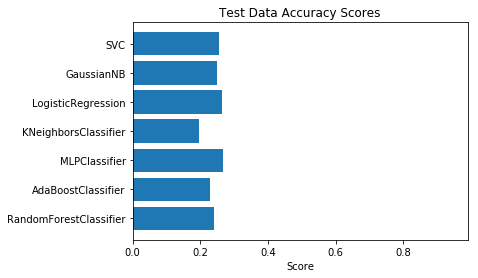

The best classifier is MLPClassifier


In [6]:
res = train_models()

In [7]:
## Accuracy score of the best classifier on all the true data.
best_clf = res[0]
best_dm_reduce = res[1]
all_pred_result = best_clf.predict(best_dm_reduce.transform(features))
accu_score = accuracy_score(labels, all_pred_result)
print("The accuracy score of the best classifier on all true data is", accu_score)
print("\n\n")

The accuracy score of the best classifier on all true data is 0.303971119133574





## **Continue to run if you have set up the fabricated file path name at the very top! **

In [15]:
def discretize(fab_features):
    fab_features['Age']   = pd.cut(fab_features['Age'],   [0, 32, 37, 42, 47, 52, 57, 62, 100],   True,   labels=[0, 1, 2, 3, 4, 5, 6, 7])
    fab_features['Bmi']   = pd.cut(fab_features['Bmi'],   [0, 18.5, 25, 30, 35, 40],              False,  labels=[0, 1, 2, 3, 4])
    fab_features['WBC']   = pd.cut(fab_features['WBC'],   [0, 4000, 11000, 13000],                True,   labels=[0, 1, 2])
    fab_features['RBC']   = pd.cut(fab_features['RBC'],   [0, 3000000, 5000000, 8000000],         False,  labels=[0, 1, 2])
    fab_features['Plat']  = pd.cut(fab_features['Plat'],  [0, 100000, 255000, 300000],            False,  labels=[0, 1, 2])


    fab_features['AST 1'] = pd.cut(fab_features['AST 1'],                 [0, 20, 40, 200], False, labels=[0, 1, 2])
    fab_features['ALT 1'] = pd.cut(fab_features['ALT 1'],                 [0, 20, 40, 200], False, labels=[0, 1, 2])
    fab_features['ALT 4'] = pd.cut(fab_features['ALT 4'],                 [0, 20, 40, 200], False, labels=[0, 1, 2])
    fab_features['ALT 12'] = pd.cut(fab_features['ALT 12'],               [0, 20, 40, 200], False, labels=[0, 1, 2])
    fab_features['ALT 24'] = pd.cut(fab_features['ALT 24'],               [0, 20, 40, 200], False, labels=[0, 1, 2])
    fab_features['ALT 36'] = pd.cut(fab_features['ALT 36'],               [0, 20, 40, 200], False, labels=[0, 1, 2])
    fab_features['ALT 48'] = pd.cut(fab_features['ALT 48'],               [0, 20, 40, 200], False, labels=[0, 1, 2])
    fab_features['ALT after 24w'] = pd.cut(fab_features['ALT after 24w'], [0, 20, 40, 200], False, labels=[0, 1, 2])


    fab_features['RNA Base'] =  pd.cut(fab_features['RNA Base'],  [0, 5, 9000000], True, labels=[0, 1])
    fab_features['RNA 4'] =     pd.cut(fab_features['RNA 4'],     [0, 5, 9000000], True, labels=[0, 1])
    fab_features['RNA 12'] =    pd.cut(fab_features['RNA 12'],    [0, 5, 9000000], True, labels=[0, 1])
    fab_features['RNA EOT'] =   pd.cut(fab_features['RNA EOT'],   [0, 5, 9000000], True, labels=[0, 1])
    fab_features['RNA EF'] =    pd.cut(fab_features['RNA EF'],    [0, 5, 9000000], True, labels=[0, 1])
    
    return fab_features

### Model 1

In [19]:
fabricated_data_file_name = 'synth1.csv'
fabricated_file_path = path + fabricated_data_file_name

if len(fabricated_data_file_name) > 0:
    fab_data = pd.read_csv(fabricated_file_path, skiprows=1, names=headers)

    fab_features = fab_data[feature_cols]
    fab_labels = fab_data[label_col]
    
    fab_features[fab_features < 0] = 5
    
    fab_features = discretize(fab_features)

    fab_pred = best_clf.predict(best_dm_reduce.transform(fab_features))
    fab_accu_score = accuracy_score(fab_labels, fab_pred)
    print("The accuracy score on original data is:", accu_score)
    print("The accuracy score on fabricated data is:", fab_accu_score)
else:
    print("Fabricated data file undefined. Please set up the path and file name at the very top of this file.\n\n")

The accuracy score on original data is: 0.303971119133574
The accuracy score on fabricated data is: 0.2571428571428571


### Model 2

In [26]:
fabricated_data_file_name = 'synth2.csv'
fabricated_file_path = path + fabricated_data_file_name

if len(fabricated_data_file_name) > 0:
    fab_data = pd.read_csv(fabricated_file_path, skiprows=1, names=headers)

    fab_features = fab_data[feature_cols]
    fab_labels = fab_data[label_col]
    
    fab_features[fab_features < 0] = 5
    
    fab_features = discretize(fab_features)

    fab_pred = best_clf.predict(best_dm_reduce.transform(fab_features))
    fab_accu_score = accuracy_score(fab_labels, fab_pred)
    print("The accuracy score on original data is:", accu_score)
    print("The accuracy score on fabricated data is:", fab_accu_score)
else:
    print("Fabricated data file undefined. Please set up the path and file name at the very top of this file.\n\n")

The accuracy score on original data is: 0.303971119133574
The accuracy score on fabricated data is: 0.30357142857142855


### Model 3

In [21]:
fabricated_data_file_name = 'synth3.csv'
fabricated_file_path = path + fabricated_data_file_name

if len(fabricated_data_file_name) > 0:
    fab_data = pd.read_csv(fabricated_file_path, skiprows=1, names=headers)

    fab_features = fab_data[feature_cols]
    fab_labels = fab_data[label_col]
    
    fab_pred = best_clf.predict(best_dm_reduce.transform(fab_features))
    fab_accu_score = accuracy_score(fab_labels, fab_pred)
    print("The accuracy score on original data is:", accu_score)t
    print("The accuracy score on fabricated data is:", fab_accu_score)
else:
    print("Fabricated data file undefined. Please set up the path and file name at the very top of this file.\n\n")

The accuracy score on original data is: 0.303971119133574
The accuracy score on fabricated data is: 0.28
